# Phase 2 Group 1 Project

## Import

In [1]:
#import appropriate libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
pd.set_option('display.max_columns', None)
import seaborn as sns
%matplotlib inline

## Review the Data File

In [2]:
#read in the file
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
#check the first 5 entries in the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
#check the columns and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Cleaning the Data

In [5]:
#for year renovated, convert any houses that have been renovated to '1' to indicate true
#for any nulls, assume no renovation
df['yr_renovated'].fillna(0, inplace=True)
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else x)

In [6]:
df.rename(columns={'yr_renovated': 'if_renovated'}, inplace=True)

In [7]:
#for any nulls, assume no waterfront
df['waterfront'].fillna(0, inplace=True)

In [8]:
#for any nulls, assume no one viewed the property
df['view'].fillna(0, inplace=True)

In [9]:
#clean up sqft_basement and convert to int
df['sqft_basement'] = df['sqft_basement'].replace({'?':np.nan}).astype(float)
df['sqft_basement'].fillna(df['sqft_living']-df['sqft_above'], inplace=True)

In [10]:
#retrieve the months and year
df['month_of_date'] = pd.DatetimeIndex(df['date']).month
df['year_of_date'] = pd.DatetimeIndex(df['date']).year

In [11]:
#convert yr_built to age of house by subtracting year the property was sold by the year it was built
#to create a more sensible column 
df['age_of_house'] = df['year_of_date'] - df['yr_built']

#drop year of date because years are only 2014 and 2015, and will not impact our predicative model
#drop yr_built b/c it is redundant with age_of_house
df.drop(columns=['year_of_date'], inplace=True)
df.drop(columns=['yr_built'], inplace=True)

In [12]:
#drop duplicates if any
df.drop_duplicates(inplace=True)

In [13]:
#drop id and date columns
df.drop(columns=['id'], inplace=True)
df.drop(columns=['date'], inplace=True)

In [14]:
#reset index
df.reset_index(inplace=True, drop=True)

In [15]:
#convert some of the categorical data from floats to ints
df['waterfront'] = df['waterfront'].astype(int)
df['view'] = df['view'].astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(int)
df['if_renovated'] = df['if_renovated'].astype(int)

In [16]:
#check cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int64  
 12  if_renovated   21597 non-null  int64  
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
 18  month_

In [17]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,if_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_of_date,age_of_house
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,0,98178,47.5112,-122.257,1340,5650,10,59
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1,98125,47.7210,-122.319,1690,7639,12,63
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,0,98028,47.7379,-122.233,2720,8062,2,82
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,0,98136,47.5208,-122.393,1360,5000,12,49
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,0,98074,47.6168,-122.045,1800,7503,2,28


In [18]:
len(df['price'])

21597

# EDA

### Target: Price

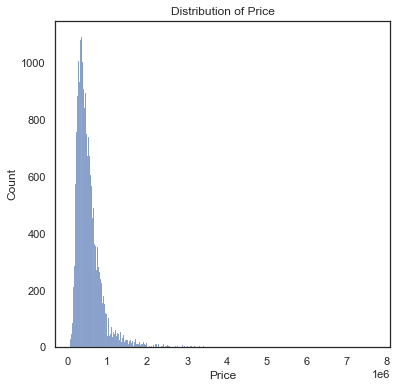

In [37]:
sns.set(style = 'white')

fig, ax = plt.subplots(figsize = (6,6))

sns.histplot(data = df, x = 'price', palette = "Dark", )

ax.set_xlabel("Price")
ax.set_ylabel("Count")
ax.set_title("Distribution of Price")

plt.show()

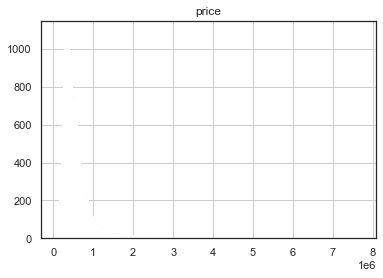

In [31]:
#Since price is our target, we will explore first
#view distribution of price using histogram
df.hist(column=['price'], bins='auto');

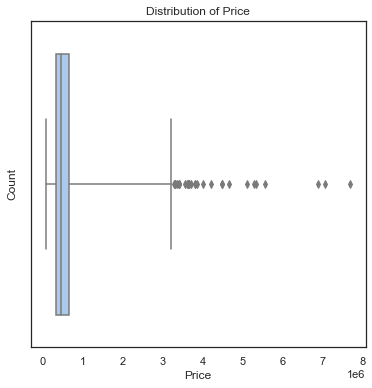

In [63]:
sns.set(style = 'white')

fig, ax = plt.subplots(figsize = (6,6))

sns.boxplot(data = df, x = 'price', palette = "pastel", fliersize = 5, whis = 8)

ax.set_xlabel("Price")
ax.set_ylabel("Count")
ax.set_title("Distribution of Price")

plt.show()

<AxesSubplot:>

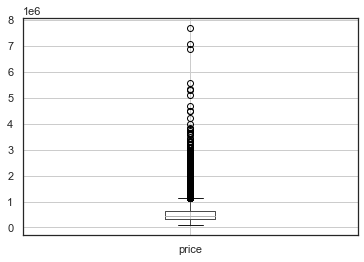

In [32]:
df.boxplot(column=['price'])

In [33]:
#Because the data is skewed to the right, transform the price data using log
df['ln_price'] = np.log(df['price'])

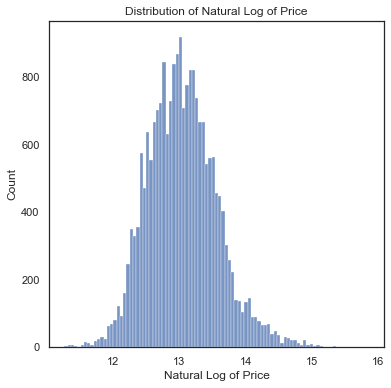

In [38]:
sns.set(style = 'white')

fig, ax = plt.subplots(figsize = (6,6))

sns.histplot(data = df, x = 'ln_price', palette = "Dark")

ax.set_xlabel("Natural Log of Price")
ax.set_ylabel("Count")
ax.set_title("Distribution of Natural Log of Price")

plt.show()

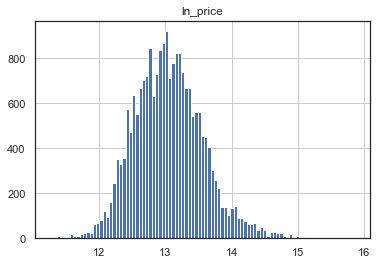

In [64]:
#view distribution of log base e for price using histogram
df.hist(column=['ln_price'], bins='auto');

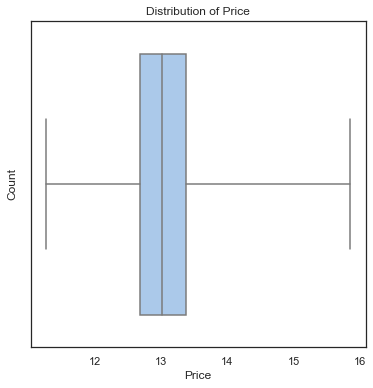

In [66]:
sns.set(style = 'white')

fig, ax = plt.subplots(figsize = (6,6))

sns.boxplot(data = df, x = 'ln_price', palette = "pastel", fliersize = 5, whis = 8)

ax.set_xlabel("Price")
ax.set_ylabel("Count")
ax.set_title("Distribution of Price")

plt.show()

<AxesSubplot:>

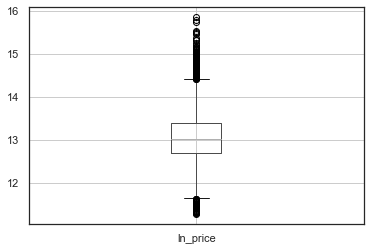

In [67]:
df.boxplot(column=['ln_price'])

### Predictors: Everything Else

In [ ]:
#sns.pairplot(df)

In [ ]:
df.columns

In [ ]:
#based on the pairplot, we can see which data are categorical and which are numeric
numeric = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above', 
           'sqft_basement',
           'lat', 
           'long',
           'sqft_living15', 
           'sqft_lot15']

categorical = ['floors',
               'waterfront', 
               'view', 
               'condition', 
               'grade',
               'if_renovated',
               'zipcode',
               'month_of_date']

In [ ]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
y = df['price']
ln_y = df['price']
heatmap_data = pd.concat([y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [ ]:
#reporting the correlation between price (target) and predictors
df.corr()['price'].drop(['ln_price']).map(abs).sort_values(ascending=False)

In [ ]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
ln_y = df['price']
heatmap_data = pd.concat([ln_y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [ ]:
#reporting the correlation between ln price (target) and predictors
df.corr()['ln_price'].drop(['price']).map(abs).sort_values(ascending=False)

In [ ]:
#here is where we drop depending what we want
drop_columns = []
df.drop(columns=drop_columns, inplace=True)

In [ ]:
#dummying categorical 
df = pd.get_dummies(df, prefix=categorical, prefix_sep='_', columns=categorical, drop_first=True)

In [ ]:
#rename the floor column heads
df.rename(columns={'floors_1.5': 'floors_1_5', 'floors_2.0': 'floors_2', 'floors_2.5': 'floors_2_5', 'floors_3.0': 'floors_3', 'floors_3.5': 'floors_3_5'}, inplace=True)

# Data Manipulation

In [ ]:
#make a new df
dfd = df
#DO NOT MAKE ANY CHANGES TO ORIGINAL DF

# Training and Testing Samples

In [ ]:
#dfd = dataframe doug

In [ ]:
#create the appropriate x and y data sets
X = dfd.drop(['price','ln_price'], axis = 1)
y = dfd['price']
ln_y = dfd['ln_price']

#scaling
ss = StandardScaler()
ss.fit(X)
X_scaled = pd.DataFrame(ss.transform(X))
X_scaled.columns = X.columns

#create the training and testing samples for both the price and ln_price data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y, test_size=0.20, random_state = 42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled, ln_y, test_size=0.20, random_state = 42)

In [ ]:
lr = LinearRegression()
lr1 = lr.fit(X_train1, y_train1)
lr2 = lr.fit(X_train2, y_train2)

results_lr1 = lr1.score(X_test1, y_test1)
results_lr2 = lr2.score(X_test2, y_test2)
results_lr1, results_lr2

In [ ]:
#stats-models OLS prediction for continous variables

df_predict_continuous = dfd[numeric]
df_target = dfd['ln_price']

#scale
df_predict_continous_scaled = (df_predict_continuous - np.mean(df_predict_continuous)) / np.std(df_predict_continuous)

#add constant
predictors = sm.add_constant(df_predict_continous_scaled)

model = sm.OLS(df_target, predictors).fit()
model.summary()

#OLS model reveals .689 R^2 for continous variables to ln_price. All variables are statistically significant 

In [ ]:
df_predict_continuous.corr()

In [ ]:
# columns = '+'.join(X.columns)

In [ ]:
# model = ols(ln_y, X).fit()
# model.summary()

In [ ]:
# ~bathrooms~sqft_living~sqft_lot~sqft_above~sqft_basement~lat~long~sqft_living15~sqft_lot15~floors~waterfront~view~condition~grade~if_renovated~zipcode~month_of_date'